In [10]:
# Import libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [28]:
def split_into_chunks(data, num_chunks=5):
    """
    Splits a list into approximately equal chunks.
    
    Parameters:
    data (list or np.array): The input data to be split.
    num_chunks (int): The number of chunks to split the data into.
    
    Returns:
    list: A list containing the split chunks.
    """
    # Convert the data to a list if it's not already a list
    data = list(data)
    
    # Determine the size of each chunk
    chunk_size = len(data) // num_chunks
    remainder = len(data) % num_chunks
    
    chunks = []
    start = 0
    
    for i in range(num_chunks):
        end = start + chunk_size + (1 if i < remainder else 0)  # Distribute the remainder
        chunks.append(data[start:end])
        start = end
    
    return chunks

In [11]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [133]:
row = cat.iloc[50]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
test_filename = row.filename
test_filename

'xa.s12.00.mhz.1973-06-18HR00_evid00109'

In [134]:
data_directory = './data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)

In [142]:
data_cat.head()

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1973-06-18T00:00:00.132000,0.000000,-3.227422e-15
1,1973-06-18T00:00:00.282943,0.150943,-4.002473e-15
2,1973-06-18T00:00:00.433887,0.301887,-4.342126e-15
3,1973-06-18T00:00:00.584830,0.452830,-4.188061e-15
4,1973-06-18T00:00:00.735774,0.603774,-3.695005e-15


In [135]:
# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

In [136]:
# Step 1: Split data into 5 chunks
num_chunks = 5
chunk_size = len(csv_times) // num_chunks
chunks = [(csv_times[i:i + chunk_size], csv_data[i:i + chunk_size]) for i in range(0, len(csv_times), chunk_size)]

In [140]:
# Step 2: Calculate noise level (e.g., variance) for each chunk
noise_levels = [np.var(chunk[1]) for chunk in chunks]  # Calculate variance of velocity for each chunk

# Step 3: Find the indices of the two chunks with the highest noise
top_two_indices = np.argsort(noise_levels)[-2:]  # Get indices of the top 2 chunks with highest noise

print(noise_levels)

[1.0418936576000712e-19, 7.898171639120072e-20, 6.732461718268396e-20, 5.338985146652145e-20, 1.4441680998697346e-21, 2.0980710753261676e-21]


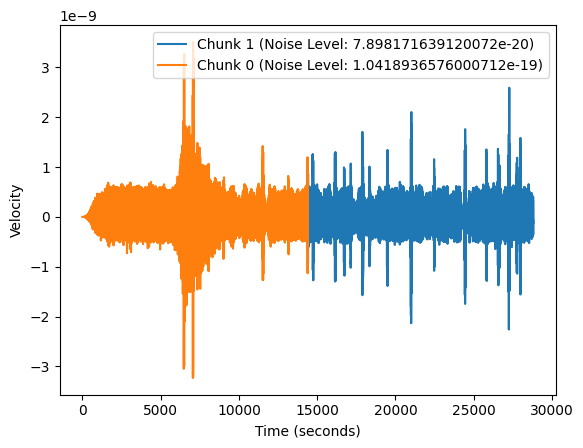

In [141]:
# Step 4: Plot the two chunks with the highest noise
fig, ax = plt.subplots()

for idx in top_two_indices:
    ax.plot(chunks[idx][0], chunks[idx][1], label=f'Chunk {idx} (Noise Level: {noise_levels[idx]})')

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Velocity')
ax.legend()
plt.show()

14400.452830188678
0.0


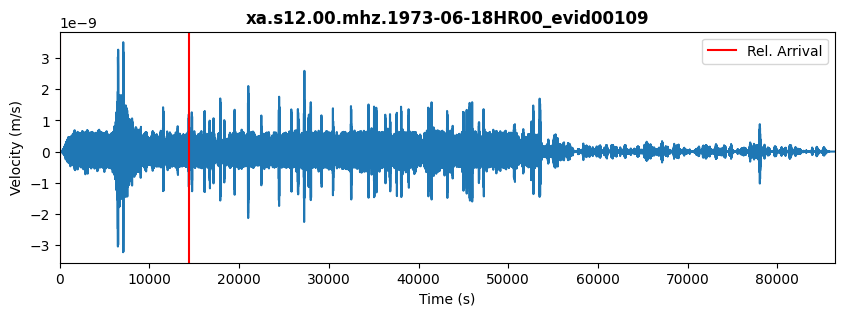

In [139]:
# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

for idx in top_two_indices:
    arrival_line = ax.axvline(x=chunks[idx][0][0], c='red', label='Rel. Arrival')
    print(chunks[idx][0][0])


ax.legend(handles=[arrival_line])